In [5]:
from numpy.matrixlib.defmatrix import matrix
from utils import *
from imutils.perspective import four_point_transform
from imutils import contours
import imutils
import matplotlib.pyplot as plt
import cv2

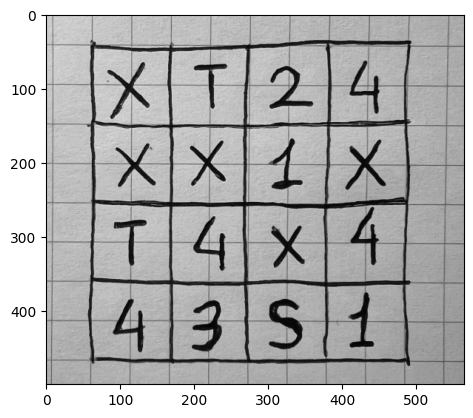

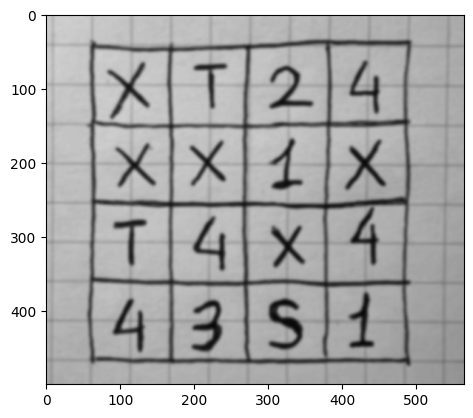

In [6]:
pathImage = "./img/maze_hand.jpg"
#pathImage = "./img/hand_new.jpg"
#pathImage = "./img/hand2.jpg"
#pathImage = "./img/maze_5.jpg"
# load the example image
img = cv2.imread(pathImage, 0)
img = imutils.resize(img, height=500)
imgX, imgY = np.shape(img)
imgOriginal = img.copy()
img = cv2.GaussianBlur(img,(11,11),0)
plt.imshow(imgOriginal,cmap='gray', vmin=0, vmax=255)
plt.show()
plt.imshow(img,cmap='gray', vmin=0, vmax=255)
plt.show()



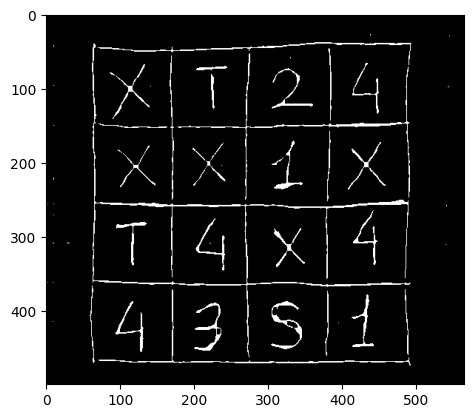

In [7]:
img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY_INV,5,2)
erode_kernel = np.ones((2, 2), np.uint8)
img = cv2.erode(img, erode_kernel, img, iterations=3)
plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.show()

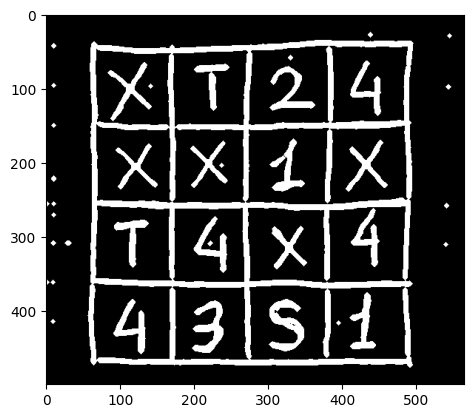

In [8]:
# Dilate using cross-type kernel
kernel = np.ones((3,3),np.uint8)
kernel[0,0] = 0
kernel[0,2] = 0
kernel[2,0] = 0
kernel[2,2] = 0
img = cv2.dilate(img, kernel, iterations=3)
plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.show()

In [9]:
import queue
# Fills connected components of white cells starting at the given point (seed) and returns the area
# of the filled portion
def customFloodFill(image,seed,color,areaType):
	q = queue.Queue()
	q.put(seed)
	rows,cols = np.shape(image)
	minX,minY,maxX,maxY = 20000,20000,0,0
	
	count = 0
	l = 1000
	while not q.empty():
		point = q.get()
		if image[point[0],point[1]] == 255:
			if point[0] < (rows/5):
				l = min(l,point[1])
			count = count + 1
			image[point[0],point[1]] = color
			for i in range(3):
				for j in range(3):
					x = point[0] + i - 1
					y = point[1] + j - 1
					if x >= 0 and y >= 0 and x < rows and y < cols:
						if image[x][y] == 255:
							q.put([x,y])
							minX = min(minX,x)
							minY = min(minY,y)
							maxX = max(maxX,x)
							maxY = max(maxY,y)
							
	boundingArea = (maxX-minX) * (maxY-minY)
	if areaType == 0:
		return image,boundingArea,l
	else: return image,count,l

In [10]:
def extractOuterGrid(img):
		rows,cols = np.shape(img)
		maxArea = 0
		point = [0,0]

		imgOriginal = img.copy()
		for i in range(rows):
			for j in range(cols):
				if img[i][j] == 255:
					img,area,dummy = customFloodFill(img,[i,j],100,0)
					if area > maxArea:
						maxArea = area
						point = [i,j]
					
		img = imgOriginal
		img,area,dummy = customFloodFill(img,[point[0],point[1]],100,0)	
		for i in range(rows):
			for j in range(cols):
				if img[i][j] == 100:
					img[i][j] = 255
				else: img[i][j] = 0
		return img,point

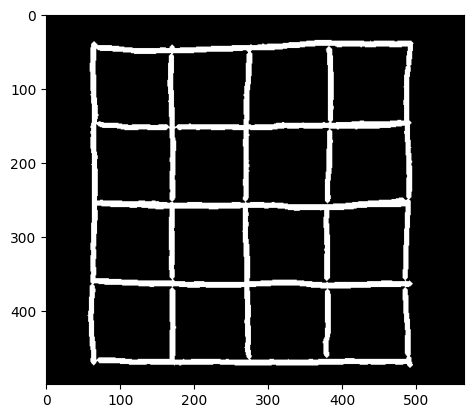

In [11]:
imgOriginal = img.copy()
img,point = extractOuterGrid(img)
plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.show()

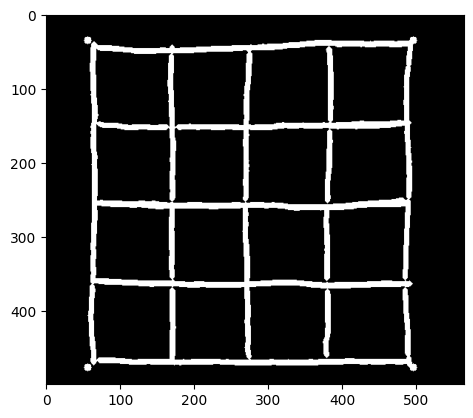

In [12]:
# Get corner points by basic algo
l,r,t,b = 1000,0,10000,0
for i in range(imgX):
	for j in range(imgY):
		if(img[i][j] == 255):
			l = min(l,j)
			r = max(r,j)
			t = min(t,i)
			b = max(t,i)
topLeft = (l,t)
topRight = (r,t)
bottomLeft = (l,b)
bottomRight = (r,b)

			
# Draw corner points on image
cv2.circle(img,topLeft,5,(255,255,255),-1)		
cv2.circle(img,topRight,5,(255,255,255),-1)		
cv2.circle(img,bottomLeft,5,(255,255,255),-1)		
cv2.circle(img,bottomRight,5,(255,255,255),-1)		
plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.show()

In [13]:
# Returns the Euclidian norm distance between two points in 2D
def getDistance(p1,p2):
	return pow(pow((p1[0]-p2[0]),2) + pow((p1[1]-p2[1]),2),0.5)

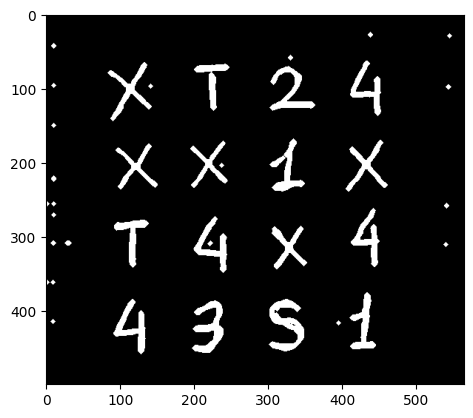

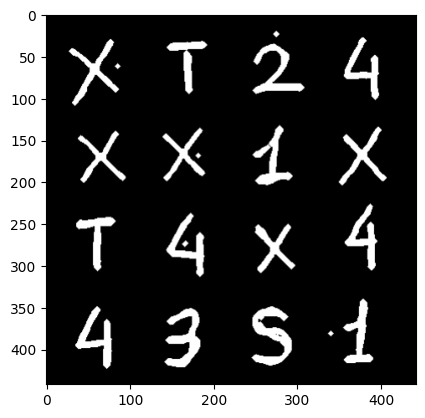

In [14]:
# Change perspective
maxLength = int(max(getDistance(topLeft,topRight),getDistance(topLeft,bottomLeft),getDistance(topRight,bottomRight),getDistance(bottomLeft,bottomRight)))
src = np.array([topLeft,topRight,bottomLeft,bottomRight])
dst = np.array([[0,0],[maxLength-1,0],[0,maxLength-1],[maxLength-1,maxLength-1]])
h,status = cv2.findHomography(src,dst)

img,area,dummy = customFloodFill(imgOriginal,[point[0],point[1]],0,0)
plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.show()
#showImage(img)
img = cv2.warpPerspective(img,h,(maxLength,maxLength))
#img = cv2.erode(img,kernel,iterations=2)
#showImage(img)


plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.show()

In [15]:
def inside(r1, r2):
    x1, y1, w1, h1 = r1
    x2, y2, w2, h2 = r2
    return (x1 > x2) and (y1 > y2) and (x1 + w1 < x2 + w2) and (y1 + h1 < y2 + h2)


def wrap_digit(rect, img_w, img_h):
    x, y, w, h = rect
    x_center = x + w // 2
    y_center = y + h // 2
    if h > w:
        w = h
        x = x_center - (w // 2)
    else:
        h = w
        y = y_center - (h // 2)

    padding = 5
    x -= padding
    y -= padding
    w += 2 * padding
    h += 2 * padding

    if x < 0:
        x = 0
    elif x > img_w:
        x = img_w

    if y < 0:
        y = 0
    elif y > img_h:
        y = img_h

    if x + w > img_w:
        w = img_w - x

    if y + h > img_h:
        h = img_h - y

    return x, y, w, h

In [16]:
def flatten(l):
    return [item for sublist in l for item in sublist]

def sortBoundingBox(rectangles): 
    _,temp,_,_ = rectangles[0]
    tempArr=[]
    outArr=[]
    for r in rectangles:
        x,y,_,_ = r
        if y < temp-15 or y > temp + 15:
            tempArr.sort(key=lambda y: y[0])
            outArr.insert(0,tempArr.copy())
            tempArr.clear()
        tempArr.append(r)
        temp = y
        
    tempArr.sort(key=lambda y: y[0])
    outArr.insert(0,tempArr.copy())
    tempArr.clear()
    """for r in outArr:
        tempArr.append(r)"""
    return flatten(outArr)

In [17]:
from tensorflow.keras.models import load_model

model = load_model("models/model.h5")

2022-11-09 11:23:40.895458: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-09 11:23:46.396892: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [18]:
import pandas as pd
mapp = pd.read_csv(
    "./datasets/new_mapping.txt", delimiter=" ", index_col=0, header=None, squeeze=True
)

/var/folders/zf/gdlmt0zj79q8jr7ktn0gx_t80000gn/T/ipykernel_1229/3729523666.py:2: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  mapp = pd.read_csv(


In [19]:
from tensorflow import expand_dims
import os

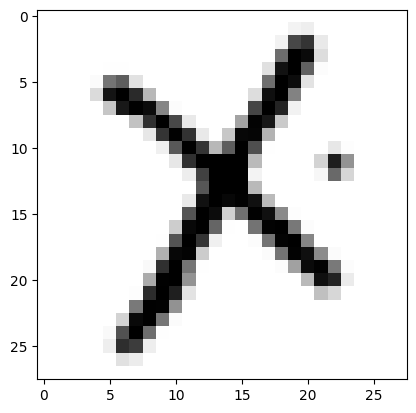

(28, 28)
(28, 28)
1/1 [==============================] - 0s 379ms/step
X


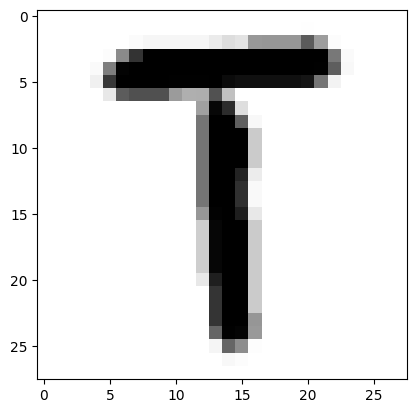

(28, 28)
(28, 28)
1/1 [==============================] - 0s 22ms/step
T


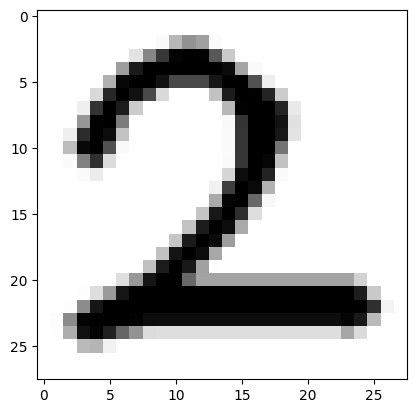

(28, 28)
(28, 28)
1/1 [==============================] - 0s 22ms/step
2


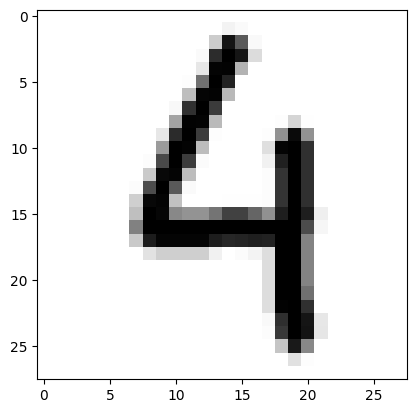

(28, 28)
(28, 28)
1/1 [==============================] - 0s 25ms/step
4


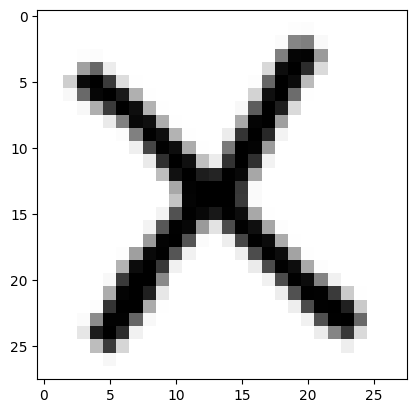

(28, 28)
(28, 28)
1/1 [==============================] - 0s 23ms/step
X


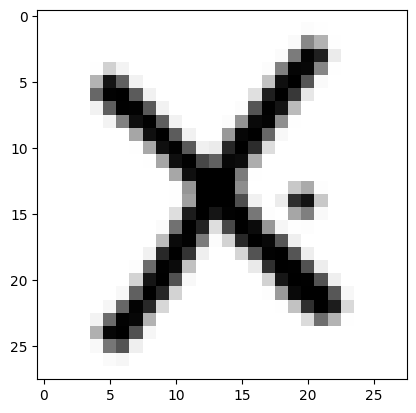

(28, 28)
(28, 28)
1/1 [==============================] - 0s 25ms/step
X


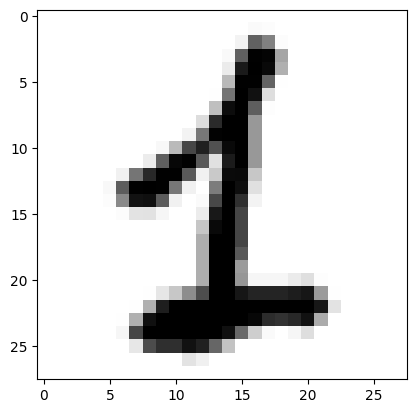

(28, 28)
(28, 28)
1/1 [==============================] - 0s 22ms/step
1


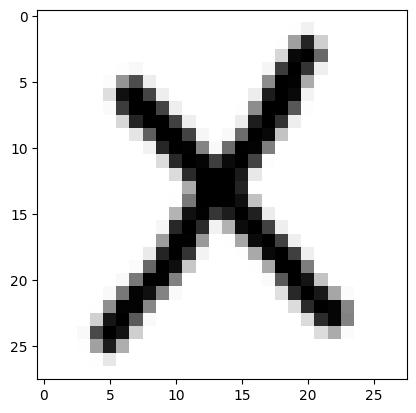

(28, 28)
(28, 28)
1/1 [==============================] - 0s 22ms/step
X


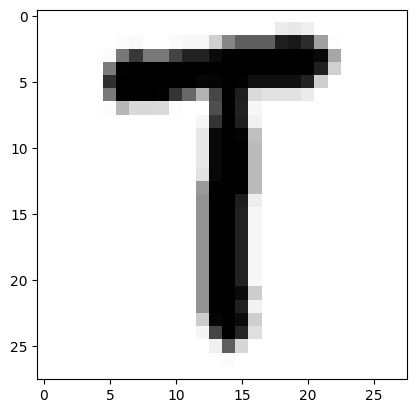

(28, 28)
(28, 28)
1/1 [==============================] - 0s 22ms/step
T


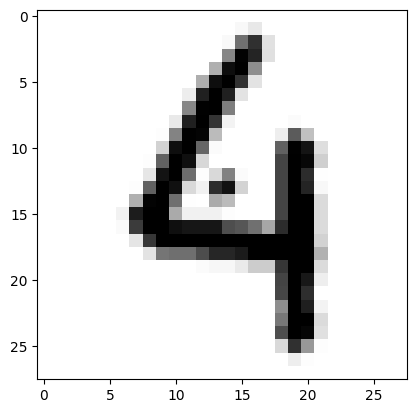

(28, 28)
(28, 28)
1/1 [==============================] - 0s 24ms/step
4


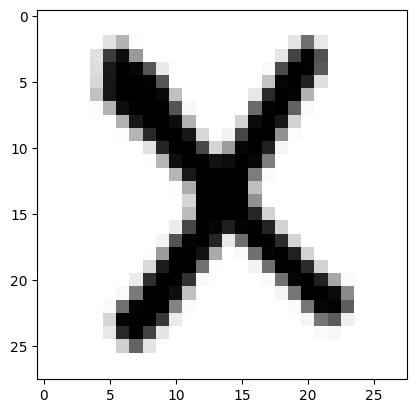

(28, 28)
(28, 28)
1/1 [==============================] - 0s 27ms/step
X


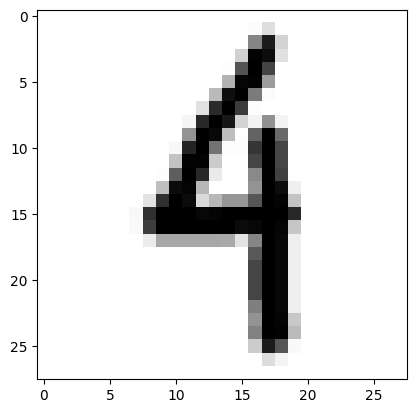

(28, 28)
(28, 28)
1/1 [==============================] - 0s 22ms/step
4


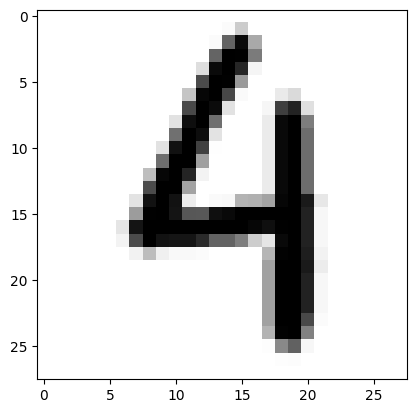

(28, 28)
(28, 28)
1/1 [==============================] - 0s 22ms/step
4


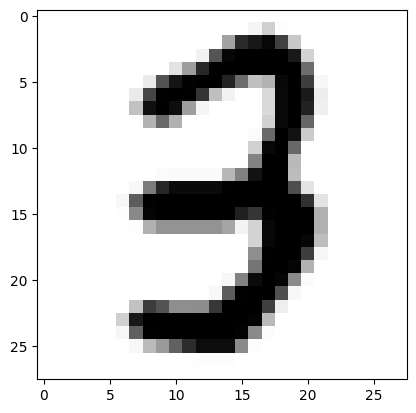

(28, 28)
(28, 28)
1/1 [==============================] - 0s 22ms/step
3


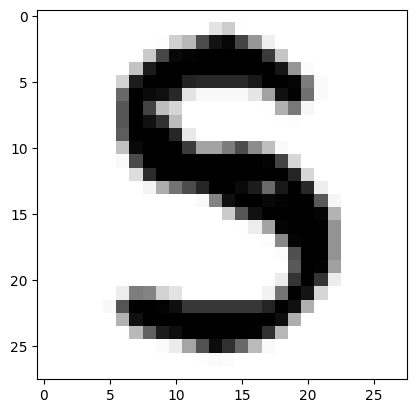

(28, 28)
(28, 28)
1/1 [==============================] - 0s 23ms/step
S


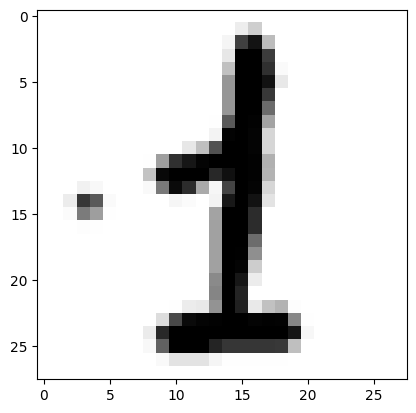

(28, 28)
(28, 28)
1/1 [==============================] - 0s 23ms/step
1


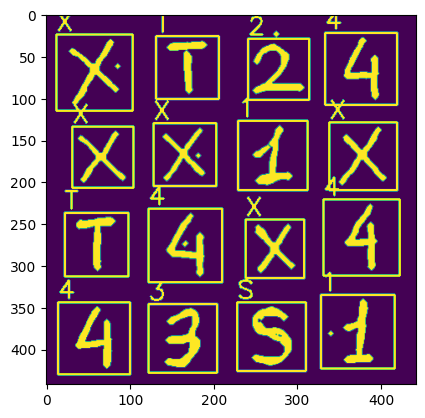

In [20]:
rectangles = []
contours, hier = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
outArr=[]

img_h, img_w = img.shape[:2]
img_area = img_w * img_h
for c in contours:
    a = cv2.contourArea(c)
    if a >= 0.98 * img_area or a <= 0.001 * img_area:
        continue

    r = cv2.boundingRect(c)
    is_inside = False
    for q in rectangles:
        if inside(r, q):
            is_inside = True
            break
    if not is_inside:
        rectangles.append(r)
count = 0
rectangles = sortBoundingBox(rectangles)
outImg = img.copy()
for r in rectangles:
    count += 1
    x, y, w, h = wrap_digit(r, img_w, img_h)
    roi = img[y : y + h, x : x + w].copy()
    
    #adapt
    roi=cv2.bitwise_not(roi)
    roi=cv2.resize(roi, (28,28), interpolation = cv2.INTER_AREA)
    plt.imshow(roi, cmap='gray', vmin=0, vmax=255)
    plt.show()
    cv2.imwrite("./test/%d.png" % count, roi)
    print(roi.shape)
    
    roi = cv2.imread("./test/%d.png" % count, 0)
    print(roi.shape)
    roi = cv2.bitwise_not(roi)
    roi = roi.astype("float32")/255

    """plt.imshow(roi, cmap='Greys')
    plt.show()"""
    roi = expand_dims(roi, axis=0)
    predictions = model.predict(roi)
    classIndex = np.argmax(predictions, axis=-1)
    print(chr(mapp[classIndex[0]]))
    outArr.append(chr(mapp[classIndex[0]]))
    if os.path.exists("./test/%d.png" % count):
        os.remove("./test/%d.png" % count)
    #predictions = model.predict(roi)
    #classIndex = np.argmax(predictions, axis=-1)
    
    cv2.rectangle(outImg, (x, y), (x + w, y + h), (255, 0, 0), 2)
    cv2.putText(
        outImg, chr(mapp[classIndex[0]]), (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2
    )

plt.imshow(outImg)
plt.show()

In [21]:
print(outArr)

['X', 'T', '2', '4', 'X', 'X', '1', 'X', 'T', '4', 'X', '4', '4', '3', 'S', '1']


In [22]:
import treasure_maze as tm

problem = tm.TreasureMaze(outArr)

_,_,node = tm.breadth_first_graph_search(problem)
tm.Game(node.path())


------------------
X O 2 4 
X 1 1 1 
O 4 1 4 
4 3 S 1 
Cost: 56
------------------
0.0007172069999796804
33

------------------
X O 2 4 
X 1 1 X 
O 4 X 4 
4 3 S 1 
Cost: 17
------------------
0.0035566670003390755
65

------------------
X O 2 4 
X X 1 X 
O 4 1 4 
4 3 S 1 
Cost: 17
------------------
0.006390166000073805
83


2022-11-09 11:23:51.168 Python[1229:8267] ApplePersistenceIgnoreState: Existing state will not be touched. New state will be written to /var/folders/zf/gdlmt0zj79q8jr7ktn0gx_t80000gn/T/org.python.python.savedState


<treasure_maze.Game object .!game>

: 